# IMDB Review Sentiment Analysis Using ModernBERT

In [1]:
import torch
import keras
import os
import re
import pickle
import datetime
import gc

import pandas as pd
import numpy as np
import plotly.express as px
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from datasets import Dataset, DatasetDict
from catboost import CatBoostClassifier
from tqdm import tqdm
from glob import glob
from functools import partial
from transformers import (
    Trainer,
    TrainingArguments,
    TrainerCallback,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    AutoModel,
    DataCollatorWithPadding,
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

2025-01-06 22:27:37.039907: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-06 22:27:37.061817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736173657.073099  754941 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736173657.078212  754941 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-06 22:27:37.090869: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Load Data

In [2]:
imdb = pd.read_csv("./imdb/IMDB Dataset.csv")
imdb

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [3]:
imdb['sentiment'] = imdb['sentiment'].map({'positive': 1, 'negative': 0})
imdb

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [4]:
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    # text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

# Apply Text Ceaning
imdb['review'] = imdb['review'].apply(clean_text)
imdb

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [5]:
def split_data(texts, labels):
    train_text, temp_text, train_labels, temp_labels = train_test_split(
        texts, labels, random_state=42, test_size=0.15, stratify=labels
    )

    val_text, test_text, val_labels, test_labels = train_test_split(
        temp_text, temp_labels, random_state=42, test_size=0.5, stratify=temp_labels
    )

    return (
        train_text,
        train_labels,
        val_text,
        val_labels,
        test_text,
        test_labels,
    )

In [6]:
(train_text, train_labels, val_text, val_labels, test_text, test_labels) = (
    split_data(imdb['review'], imdb['sentiment'])
)

print(f"訓練集大小: {len(train_text)}")
print(f"驗證集大小: {len(val_text)}")
print(f"測試集大小: {len(test_text)}")

訓練集大小: 42500
驗證集大小: 3750
測試集大小: 3750


In [7]:
train = {
    'sentence1': train_text,
    'label': train_labels,
    'idx': list(range(len(train_text)))
}

val = {
    'sentence1': val_text,
    'label': val_labels,
    'idx': list(range(len(val_text)))
}

test = {
    'sentence1': test_text,
    'label': test_labels,
    'idx': list(range(len(test_text)))
}

In [8]:
train_dataset = Dataset.from_dict(train)
val_dataset = Dataset.from_dict(val)
test_dataset = Dataset.from_dict(test)

In [9]:
raw_datasets = DatasetDict({
    'train': train_dataset,
    'val': val_dataset,
    'test': test_dataset,
})
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'label', 'idx'],
        num_rows: 42500
    })
    val: Dataset({
        features: ['sentence1', 'label', 'idx'],
        num_rows: 3750
    })
    test: Dataset({
        features: ['sentence1', 'label', 'idx'],
        num_rows: 3750
    })
})

In [10]:
print(f"{raw_datasets}\n")
print(f"{raw_datasets["train"][0]}\n")
print(f"{raw_datasets["train"].features}\n")

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'label', 'idx'],
        num_rows: 42500
    })
    val: Dataset({
        features: ['sentence1', 'label', 'idx'],
        num_rows: 3750
    })
    test: Dataset({
        features: ['sentence1', 'label', 'idx'],
        num_rows: 3750
    })
})

{'sentence1': 'The film has no connection with the real life in Bosnia in those days. Should be more realistic and shows the viewer real traumas that were happening to common people during the war. Please see some films of Yugoslav authors (Emir Kusturica, Ljubisa Samardzic,...e.g. Bure baruta( A barrel of powder), Tito i ja (Tito and me), Lepa sela lepo gore (Beautiful Villages burn Beautiful), etc... Just this is the real way to know about so called Bosnian problem. Hollywood is definitive not th right address to make films about the Balcan peninsula. Maybe Vietnam, WW II,... but not of the Slavs living in former Yugoslavia.', 'label': 0, 'idx': 0}

{'sentence1': Value(dtyp

## Tokenize

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base")

def process_function(texts, inputs):
    inps = [texts[inp] for inp in inputs]
    tokenized = tokenizer(*inps, padding=False, truncation=True, max_length=8192)
    return tokenized

In [12]:
inputs = ['sentence1']

In [13]:
tokenized_datasets = raw_datasets.map(partial(process_function, inputs=inputs), batched=True)

print(f"{tokenized_datasets}\n")
print(f"{tokenized_datasets["train"][0]}\n")
print(f"{tokenized_datasets["train"].features}\n")

Map:   0%|          | 0/42500 [00:00<?, ? examples/s]

Map:   0%|          | 0/3750 [00:00<?, ? examples/s]

Map:   0%|          | 0/3750 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 42500
    })
    val: Dataset({
        features: ['sentence1', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 3750
    })
    test: Dataset({
        features: ['sentence1', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 3750
    })
})

{'sentence1': 'The film has no connection with the real life in Bosnia in those days. Should be more realistic and shows the viewer real traumas that were happening to common people during the war. Please see some films of Yugoslav authors (Emir Kusturica, Ljubisa Samardzic,...e.g. Bure baruta( A barrel of powder), Tito i ja (Tito and me), Lepa sela lepo gore (Beautiful Villages burn Beautiful), etc... Just this is the real way to know about so called Bosnian problem. Hollywood is definitive not th right address to make films about the Balcan peninsula. Maybe Vietnam, WW II,... but no

In [14]:
tokenizer.decode(tokenized_datasets["train"][15000]["input_ids"])

'[CLS]I swear, I had never seen such a bad movie as Half Caste is. Not only because it just makes no sense, is a huge piece of egolatry and self-confidence that makes me puke.Sebastian Apocada (in Spanish Apocada has a similar pronunciation to "apocado" which means "out of life and happiness") makes here a one man army movie thinking he is Sam Raimi or the boys who directed the Blair Witch project. This is the Blair Kittie project, with an expensive low budget.The story, a couple of American Filmmakers that go to Africa to make a documentary of the Half Caste, is just no-sense. The way of filming, inserting high speed shots with slow motion shots, just revolts your stomach more than the stupid lines (what the hell is that dialog about Bestiality?) or the lame performances. By the way, I don\'t believe this cast (or caste?) is American, they all look European to me.To finish this, just say that the filmmakers made an intelligent move about selling the movie. They put a fake award achiev

In [15]:
labels = ["negative", "positive"]
num_labels = len(labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

## Load Model

In [16]:
model = AutoModelForSequenceClassification.from_pretrained("answerdotai/ModernBERT-base", num_labels=2, id2label=id2label, label2id=label2id)

print(summary(model))
model.to(device)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Layer (type:depth-idx)                                       Param #
ModernBertForSequenceClassification                          --
├─ModernBertModel: 1-1                                       --
│    └─ModernBertEmbeddings: 2-1                             --
│    │    └─Embedding: 3-1                                   38,682,624
│    │    └─LayerNorm: 3-2                                   768
│    │    └─Dropout: 3-3                                     --
│    └─ModuleList: 2-2                                       --
│    │    └─ModernBertEncoderLayer: 3-4                      5,014,272
│    │    └─ModernBertEncoderLayer: 3-5                      5,015,040
│    │    └─ModernBertEncoderLayer: 3-6                      5,015,040
│    │    └─ModernBertEncoderLayer: 3-7                      5,015,040
│    │    └─ModernBertEncoderLayer: 3-8                      5,015,040
│    │    └─ModernBertEncoderLayer: 3-9                      5,015,040
│    │    └─ModernBertEncoderLayer: 3-10        

ModernBertForSequenceClassification(
  (model): ModernBertModel(
    (embeddings): ModernBertEmbeddings(
      (tok_embeddings): Embedding(50368, 768, padding_idx=50283)
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (layers): ModuleList(
      (0): ModernBertEncoderLayer(
        (attn_norm): Identity()
        (attn): ModernBertAttention(
          (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
          (rotary_emb): ModernBertRotaryEmbedding()
          (Wo): Linear(in_features=768, out_features=768, bias=False)
          (out_drop): Identity()
        )
        (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): ModernBertMLP(
          (Wi): Linear(in_features=768, out_features=2304, bias=False)
          (act): GELUActivation()
          (drop): Dropout(p=0.0, inplace=False)
          (Wo): Linear(in_features=1152, out_features=768, bias=False)
        )
      

## Train ModernBERT

In [17]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [18]:
# data_collator

In [19]:
class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.training_history = {"train": [], "eval": []}
        
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                self.training_history["train"].append(logs)
            elif "eval_loss" in logs:
                self.training_history["eval"].append(logs)

In [20]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average="binary"
    )
    acc = accuracy_score(labels, predictions)

    return {
        f"accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }

In [21]:
for param in model.base_model.parameters():
    param.requires_grad = False
    
for param in model.base_model.layers[-1:].parameters():
    param.requires_grad = True
    
for param in model.base_model.final_norm.parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

In [22]:
for name, param in model.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")

model.embeddings.tok_embeddings.weight: Frozen
model.embeddings.norm.weight: Frozen
model.layers.0.attn.Wqkv.weight: Frozen
model.layers.0.attn.Wo.weight: Frozen
model.layers.0.mlp_norm.weight: Frozen
model.layers.0.mlp.Wi.weight: Frozen
model.layers.0.mlp.Wo.weight: Frozen
model.layers.1.attn_norm.weight: Frozen
model.layers.1.attn.Wqkv.weight: Frozen
model.layers.1.attn.Wo.weight: Frozen
model.layers.1.mlp_norm.weight: Frozen
model.layers.1.mlp.Wi.weight: Frozen
model.layers.1.mlp.Wo.weight: Frozen
model.layers.2.attn_norm.weight: Frozen
model.layers.2.attn.Wqkv.weight: Frozen
model.layers.2.attn.Wo.weight: Frozen
model.layers.2.mlp_norm.weight: Frozen
model.layers.2.mlp.Wi.weight: Frozen
model.layers.2.mlp.Wo.weight: Frozen
model.layers.3.attn_norm.weight: Frozen
model.layers.3.attn.Wqkv.weight: Frozen
model.layers.3.attn.Wo.weight: Frozen
model.layers.3.mlp_norm.weight: Frozen
model.layers.3.mlp.Wi.weight: Frozen
model.layers.3.mlp.Wo.weight: Frozen
model.layers.4.attn_norm.weight:

In [23]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"可訓練參數數量: {trainable_params}")

可訓練參數數量: 5607938


In [24]:
torch.set_float32_matmul_precision('high')

In [25]:
epochs = 10

In [26]:
now = datetime.datetime.now()
formatted_time = now.strftime("%Y-%m-%d_%H-%M")

training_args = TrainingArguments(
    output_dir=f"./imdb/modernbert/results/{formatted_time}",
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=5e-5,
    lr_scheduler_type="linear",
    optim="adamw_torch",
    adam_beta1=0.9,
    adam_beta2=0.98,
    adam_epsilon=1e-6,
    warmup_ratio=0.4,
    weight_decay=0.01,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=epochs,
    logging_dir=f"./imdb/modernbert/logs/{formatted_time}",
    logging_steps=epochs,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["val"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

metrics_callback = MetricsCallback()
trainer.add_callback(metrics_callback)

trainer.train()

train_history_df = pd.DataFrame(metrics_callback.training_history["train"])
train_history_df = train_history_df.add_prefix("train_")
eval_history_df = pd.DataFrame(metrics_callback.training_history["eval"])
# train_res_df = pd.concat([train_history_df, eval_history_df], axis=1)

args_df = pd.DataFrame([training_args.to_dict()])

display(train_history_df)
display(args_df)

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.246100,0.323716,0.868800,0.870116,0.861474,0.878933
2,0.279600,0.282502,0.890400,0.885099,0.930082,0.844267
3,0.305000,0.239867,0.909600,0.906328,0.940367,0.874667
4,0.152600,0.332151,0.885600,0.874964,0.964653,0.800533
5,0.096400,0.217033,0.919467,0.917215,0.943598,0.892267
6,0.276900,0.214843,0.928267,0.927435,0.938319,0.916800
7,0.261500,0.232227,0.929600,0.929032,0.936585,0.921600
8,0.074700,0.337819,0.921067,0.918187,0.952955,0.885867
9,0.171000,0.367193,0.926667,0.926998,0.922833,0.931200
10,0.174100,0.370728,0.926933,0.926660,0.930145,0.923200


,train_loss,train_grad_norm,train_learning_rate,train_epoch
0,0.8216,7.271369,2.352720e-08,0.001882
1,0.7831,3.938524,4.705439e-08,0.003764
2,0.6813,9.334281,7.058159e-08,0.005647
3,0.7388,8.057901,9.410879e-08,0.007529
4,0.7943,6.857945,1.176360e-07,0.009411
...,...,...,...,...
5308,0.0270,0.012595,6.273919e-08,9.992471
5309,0.0212,2.438682,4.705439e-08,9.994353
5310,0.0308,0.490124,3.136960e-08,9.996236
5311,0.0739,1.028501,1.568480e-08,9.998118


,output_dir,overwrite_output_dir,do_train,do_eval,do_predict,eval_strategy,prediction_loss_only,per_device_train_batch_size,per_device_eval_batch_size,per_gpu_train_batch_size,...,split_batches,include_tokens_per_second,include_num_input_tokens_seen,neftune_noise_alpha,optim_target_modules,batch_eval_metrics,eval_on_start,use_liger_kernel,eval_use_gather_object,average_tokens_across_devices
0,./imdb/modernbert/results/2025-01-06_22-27,False,False,True,False,epoch,False,8,8,None,...,None,False,False,None,None,False,False,False,False,False


## Predict

In [27]:
trainer.evaluate()

{'eval_loss': 0.37072765827178955,
 'eval_accuracy': 0.9269333333333334,
 'eval_f1': 0.9266595289079229,
 'eval_precision': 0.9301450832885545,
 'eval_recall': 0.9232,
 'eval_runtime': 40.3026,
 'eval_samples_per_second': 93.046,
 'eval_steps_per_second': 11.637,
 'epoch': 10.0}

In [28]:
predictions = trainer.predict(tokenized_datasets["test"])
print(predictions.predictions.shape, predictions.label_ids.shape)

(3750, 2) (3750,)


In [29]:
preds = np.argmax(predictions.predictions, axis=-1)
preds

array([0, 0, 1, ..., 0, 1, 0])

In [30]:
test = pd.DataFrame({'Text': test_text, 'Pred Label': preds, 'Label': test_labels})
test[:10]

,Text,Pred Label,Label
48433,"I think the film is educational. However, it f...",0,1
41274,"The opening was a steal from ""Eight-legged Fre...",0,0
26643,The documentary presents an original theory ab...,1,1
29683,"With all of its technical flash, the 1993 ""Sta...",1,0
34790,I hope we never become to cynical as a society...,1,1
19457,"I am not a huge fan of camp kitsch and the ""so...",1,1
37945,This brings back so many childhood memories. (...,1,1
23809,Probably the most whimsical installment of the...,1,1
16206,"I like Billy Crystal, and I thought it would b...",0,0
5009,These type of movies about young teenagers str...,1,1


Accuracy: 0.9285

Classification report: 
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1875
           1       0.93      0.93      0.93      1875

    accuracy                           0.93      3750
   macro avg       0.93      0.93      0.93      3750
weighted avg       0.93      0.93      0.93      3750



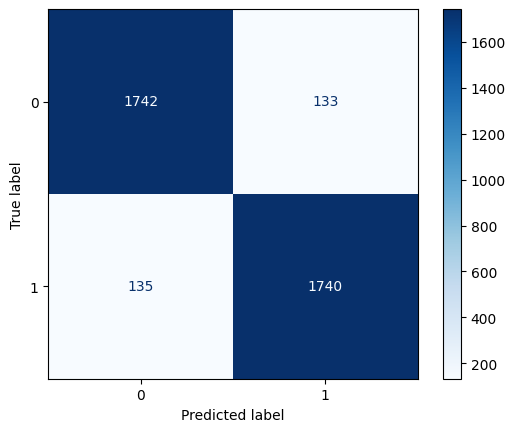

In [31]:
accuracy = accuracy_score(test_labels, preds)
cm = confusion_matrix(test_labels, preds, labels=[0, 1])

print(f"Accuracy: {accuracy:.4f}")
report = classification_report(test_labels, preds)
print(f"\nClassification report: \n{report}")

disp = ConfusionMatrixDisplay(
            confusion_matrix=cm, display_labels=[0, 1]
        )
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Save Model

In [32]:
model.save_pretrained(f"./imdb/models/finetuned_modernbert_{formatted_time}")